In [11]:
import cv2
import numpy as np


# 1. Filtrado Gaussiano
def apply_gaussian_blur(image, kernel_size=5, sigma=1.0):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)


# 2. Filtro de Mediana
def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)


# 3. CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Si la imagen está en color, convertir a escala de grises
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)


# 4. Transformación homomórfica
# def apply_homomorphic_filter(image: np.ndarray, radius: int = 13, blur_kernel: int = 47) -> np.ndarray:
#     """
#     Aplica un filtro homomórfico a una imagen en escala de grises utilizando FFT de numpy y
#     una máscara de paso alto con desenfoque gaussiano.

#     Parámetros:
#     - image: np.ndarray - Imagen de entrada en escala de grises (8 bits).
#     - radius: int - Radio del círculo central que se atenuará (más bajo, más detalle).
#     - blur_kernel: int - Tamaño del kernel gaussiano para suavizar la máscara.

#     Retorna:
#     - Imagen filtrada y normalizada en uint8.
#     """

#     # Convertir a float64 y aplicar logaritmo
#     img_log = np.log(np.float64(image) + 1e-6)  # evitar log(0)

#     # FFT 2D
#     dft = np.fft.fft2(img_log)
#     dft_shift = np.fft.fftshift(dft)

#     # Crear máscara de paso alto centrada
#     rows, cols = image.shape
#     cy, cx = rows // 2, cols // 2
#     mask = np.zeros((rows, cols), dtype=np.float64)
#     cv2.circle(mask, (cx, cy), radius, 1, thickness=-1)
#     mask = 1 - mask  # invertir (pasa altos)

#     # Suavizar máscara (antialias)
#     mask = cv2.GaussianBlur(mask, (blur_kernel, blur_kernel), 0)

#     # Aplicar máscara al espectro de Fourier
#     dft_shift_filtered = dft_shift * mask

#     # Inversa
#     dft_ishift = np.fft.ifftshift(dft_shift_filtered)
#     img_back = np.fft.ifft2(dft_ishift)
#     img_back = np.abs(img_back)

#     # Revertir log con exponencial
#     img_exp = np.exp(img_back)

#     # Normalizar a uint8
#     img_norm = cv2.normalize(img_exp, None, 0, 255, cv2.NORM_MINMAX)
#     return img_norm.astype(np.uint8)


def filtro_gaussiano_livro(img, gl, gh, inc, Dz):
    P = img.shape[0] / 2
    Q = img.shape[1] / 2
    U, V = np.meshgrid(range(img.shape[0]), range(img.shape[1]), indexing='ij')
    d = ((U - P) ** 2 + (V - Q) ** 2).astype(float)
    h = (gh - gl) * (1 - np.exp(-inc * (d / (Dz ** 2)))) + gl
    return h

def filtro_gaussiano(img, Dz):
    P = img.shape[0] / 2
    Q = img.shape[1] / 2
    U, V = np.meshgrid(range(img.shape[0]), range(img.shape[1]), indexing='ij')
    d = ((U - P) ** 2 + (V - Q) ** 2).astype(float)
    h = 1 - np.exp(-(d / (2 * (Dz ** 2))))
    return h

def uint8_conv(img):
    img_clipped = np.clip(img, 0, 255)
    return np.uint8(img_clipped)

def reescalona(img, min_val, max_val):
    img_rescaled = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalizar 0-1
    img_rescaled = img_rescaled * (max_val - min_val) + min_val
    return np.uint8(img_rescaled)

def apply_homomorphic_filter(img, l=300, s=1):
    """
    Aplica filtro homomórfico con dos opciones de filtro gaussiano.

    Parámetros:
    - img: imagen grayscale uint8 o float
    - l: parámetro Dz que controla la frecuencia de corte del filtro
    - s: tipo de filtro (0=gaussiano básico, 1=filtro tipo libro)

    Retorna:
    - imagen filtrada uint8
    """
    im = np.float64(img)
    if s == 0:
        f = filtro_gaussiano(im, l)
    elif s == 1:
        f = filtro_gaussiano_livro(im, 0.05, 3.5, 1, l)
    else:
        raise ValueError("s debe ser 0 o 1")

    im_log = np.log1p(im)  # log(1+I) para evitar log(0)
    Im_shift = np.fft.fftshift(np.fft.fft2(im_log))
    Im_fft_filt = f * Im_shift
    Im_filt = np.real(np.fft.ifft2(np.fft.ifftshift(Im_fft_filt)))
    Im_exp = np.exp(Im_filt) - 1
    Im_rescaled = reescalona(Im_exp, 0, 255)
    return uint8_conv(Im_rescaled)

# 5. Detección de bordes (Canny)
def apply_edge_detection(image, threshold1=50, threshold2=150):
    # Asegurarse de trabajar en escala de grises
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(image, threshold1, threshold2)


In [12]:
import matplotlib.pyplot as plt
import numpy as np


def plot_side_by_side(image1, image2, title="Comparación de Imágenes"):
    # Asegurar que las imágenes sean arrays tipo uint8 de 2D
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)

    # Forzar el estilo y fondo blanco
    plt.rcParams.update(
        {
            "font.family": "Times New Roman",
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "text.color": "black",
            "axes.labelcolor": "black",
            "xtick.color": "black",
            "ytick.color": "black",
            "axes.edgecolor": "black",
        }
    )

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # fig.suptitle(title, fontsize=16)s

    axes[0].imshow(image1, cmap="gray", vmin=0, vmax=255)
    axes[0].set_title("a)", fontsize=12)
    axes[0].axis("off")

    axes[1].imshow(image2, cmap="gray", vmin=0, vmax=255)
    axes[1].set_title("b)", fontsize=12)
    axes[1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # espacio para el título
    plt.show()


In [13]:
from src.image_utils import *

In [14]:
nii = load_nii("datasets/computed-tomography/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans/090.nii")
nii, _ = get_windowed_image(nii)
nii = get_nii_as_list(nii)

In [15]:
img = nii[16]
img = np.rot90(img, k=1)

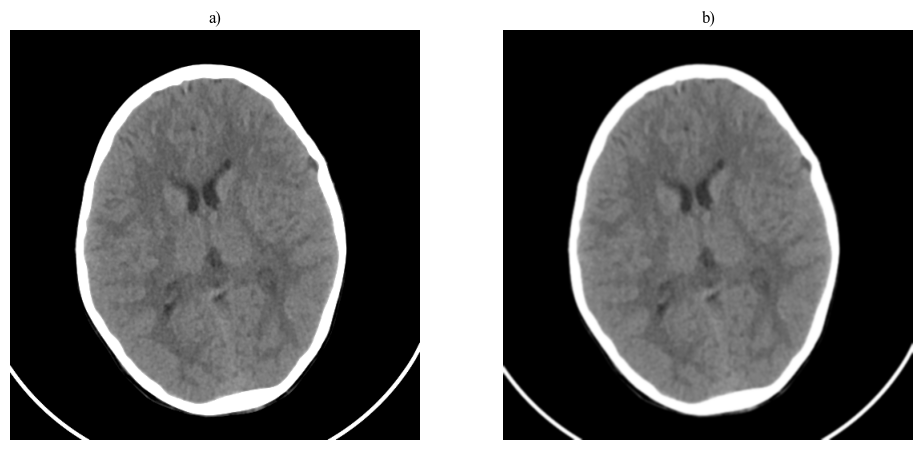

In [16]:
img2 = apply_gaussian_blur(img)
plot_side_by_side(img, img2, "Filtrado Gaussiano")

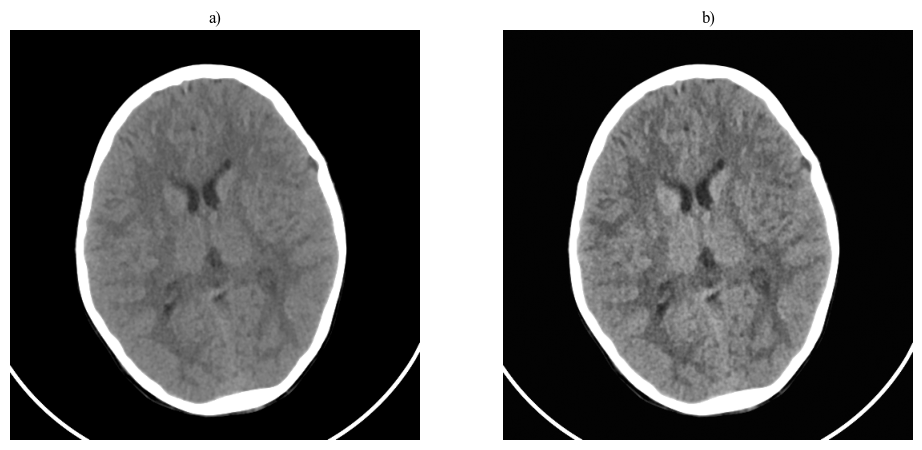

In [17]:
img3 = apply_clahe(img)
plot_side_by_side(img, img3, "CLAHE")

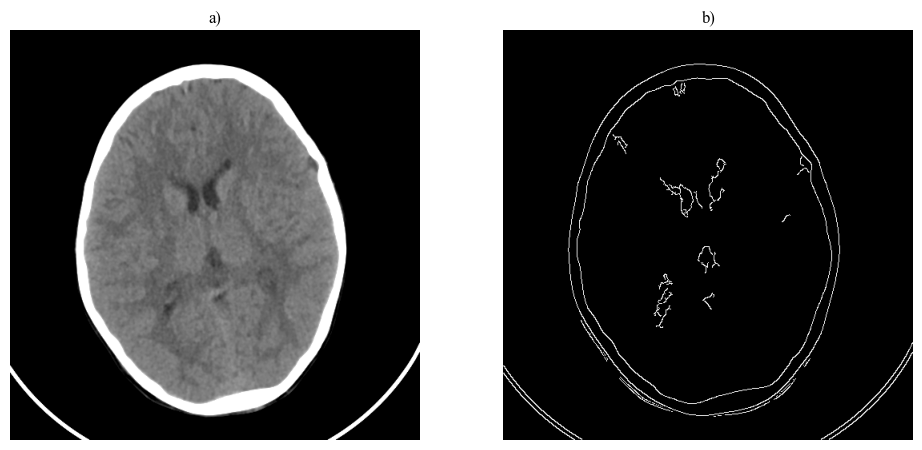

In [18]:
img4 = apply_edge_detection(img)
plot_side_by_side(img, img4, "Detección de bordes(Canny)")

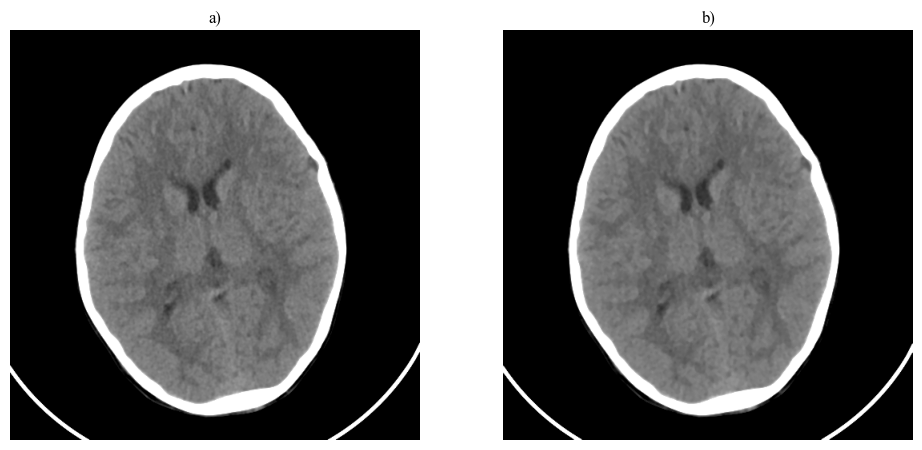

In [19]:
img5 = apply_median_filter(img)
plot_side_by_side(img, img5, "Filtrado de Mediana")

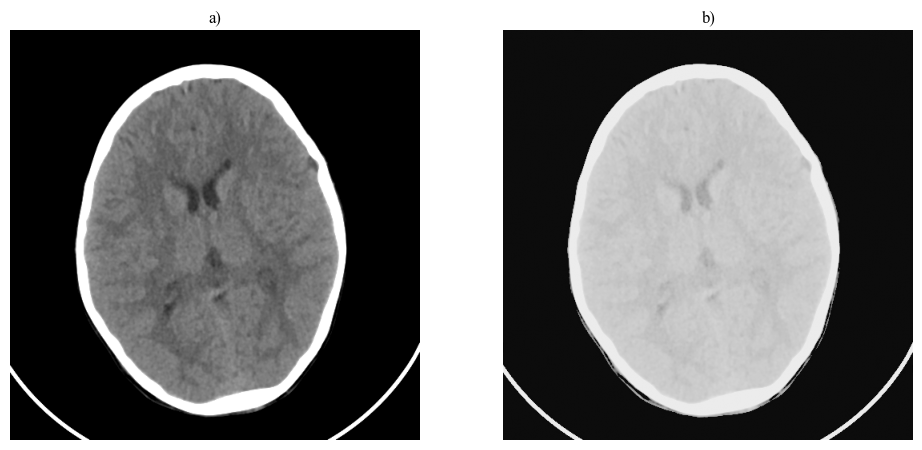

In [20]:
img6 = apply_homomorphic_filter(img, l=5000, s=1)
plot_side_by_side(img, img6, "Transformación Homomórfica")